# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [265]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [266]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [267]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [268]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [269]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [270]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")


#### Fonction quadratique

In [271]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

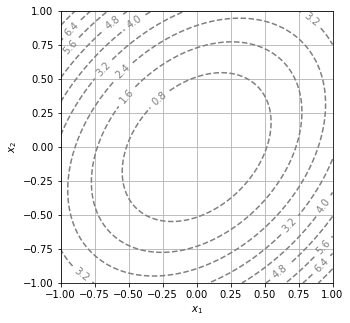

In [272]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [273]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

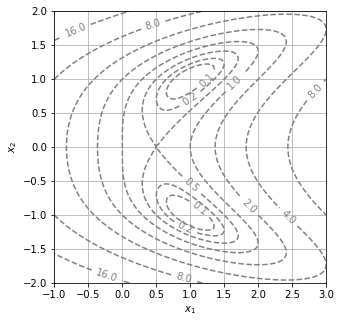

In [274]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [275]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

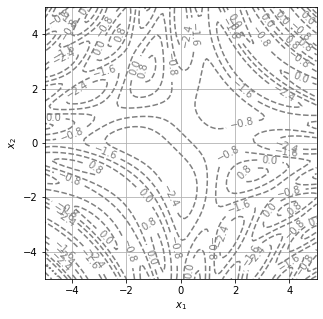

In [276]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [277]:
N = 100
eps = 10**(-3)

On choisit $\varepsilon$ tel que l'erreur n'impacte pas la lecture graphique (donc  $\varepsilon < 10^{-2}$) sans demander un résultat trop précis pour que les erreurs d'arrondis ne soient pas dérangeantes.

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [278]:
def Newton(F, x0, y0, eps=eps, N=N):
   

    for i in range(N):
        
        X = np.array([x0,y0])-np.linalg.inv(J(F)(x0,y0))@F(x0,y0)
        x, y = X[0], X[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [279]:
def F1y_x(x,y): # on définit une fonction telle que F1test=0 quand f1=0 et y=x
    return np.array([f1(x,y)-0.8,x-y])

Première vérification : on part de (0.8,0.8), on trouve le point (0.4472135970019964, 0.4472135970019964) 
 On vérifie que en ce point, f1 vaut 0.8000000053738563 
 

Deuxième vérification : on part de (-0.8,-0.8), on trouve le point (-0.4472135970019964, -0.4472135970019964) 
 On vérifie que en ce point, f1 vaut 0.8000000053738563 
 

Troisième vérification : on part de (2.0,0.5), on trouve le point (0.44721359550391493, 0.44721359550391493) 
 On vérifie que en ce point, f1 vaut 0.8000000000141569 
 

Quatrième vérification : on part de (-1.5,1.0), on trouve le point (-0.44721363549211096, -0.44721363549211096) 
 On vérifie que en ce point, f1 vaut 0.8000001430802827 
 

Cela correspond, l'axe y=x coupe bien la courbe de niveau en deux points opposés


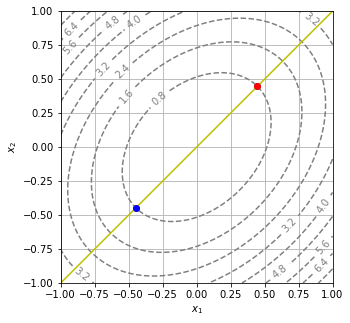

In [280]:
X1,Y1=Newton(F1y_x,0.8,0.8)
X2,Y2=Newton(F1y_x,-0.8,-0.8)
X3,Y3=Newton(F1y_x,2.0,0.5)
X4,Y4=Newton(F1y_x,-1.5,1.0)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
X=np.linspace(-1.0, 1.0, 100)
plt.plot(X,X,color = 'y') #on affiche l'axe y=x
plt.plot(X1, Y1,'o') #on affiche les solutions données par la fonction Newton
plt.plot(X2,Y2,'o')
plt.plot(X3,Y3,'o',color='r')
plt.plot(X4,Y4,'o',color='b')

print(f"Première vérification : on part de (0.8,0.8), on trouve le point {X1,Y1} \n On vérifie que en ce point, f1 vaut {f1(X1,Y1)} \n \n")
print(f"Deuxième vérification : on part de (-0.8,-0.8), on trouve le point {X2,Y2} \n On vérifie que en ce point, f1 vaut {f1(X2,Y2)} \n \n")
print(f"Troisième vérification : on part de (2.0,0.5), on trouve le point {X3,Y3} \n On vérifie que en ce point, f1 vaut {f1(X3,Y3)} \n \n")
print(f"Quatrième vérification : on part de (-1.5,1.0), on trouve le point {X4,Y4} \n On vérifie que en ce point, f1 vaut {f1(X4,Y4)} \n \n")
print("Cela correspond, l'axe y=x coupe bien la courbe de niveau en deux points opposés")

plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

On construit chaque point successivement. Pour construire le point suivant, on cherche l'intersection entre la courbe de niveau de valeur c et le cercle dont le centre est le point précédent et de rayon delta. On utilise pour cela la méthode de Newton avec la fonction F1cercle définie telle que F1cercle=0 pour f(x,y)=c et pour (x-x0)²+(y-y0)² = delta².

In [281]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c=f(x0,y0)
    res=np.full((N,2),[x0,y0])
    gradf=grad(f)
    def F1cercle(x,y):
        return np.array([f(x,y)-c,((y-y0)**2+(x-x0)**2)-delta**2])
    for i in range (N-1):
        nablaf=gradf(x0,y0)
        ortho=np.array([nablaf[1],-nablaf[0]])
        orthonorm=ortho*(1/np.linalg.norm(ortho))
        x1 = x0 + orthonorm[0]*delta
        y1 = y0 + orthonorm[1]*delta
        Xnew,Ynew=Newton(F1cercle,x1,y1)
        res[i,0]=Xnew
        res[i,1]=Ynew
        x0,y0=Xnew,Ynew
    return res

On vérifie que cela fonctionne avec f1 :

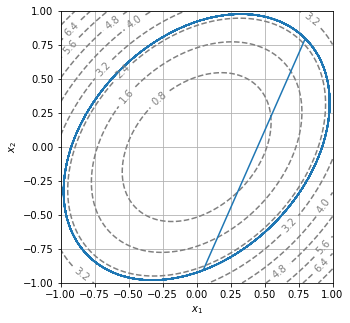

In [282]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
A=level_curve(f1,0.8,0.8)
X=A[:,0]
Y=A[:,1]
plt.plot(X,Y)
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [283]:
def level_curvebis(f, x0, y0, delta=0.1, N=1000, eps=eps):
   c=f(x0,y0)
   res=np.full((N,2),[x0,y0])
   gradf=grad(f)
   def F1cercle(x,y):
         return np.array([f(x,y)-c,((y-y0)**2+(x-x0)**2)-delta**2])
   for i in range (N-1):
      nablaf=gradf(x0,y0)
      ortho=np.array([nablaf[1],-nablaf[0]])
      orthonorm=ortho*(1/np.linalg.norm(ortho))
      x1 = x0 + orthonorm[0]*delta
      y1 = y0 + orthonorm[1]*delta
      Xnew,Ynew=Newton(F1cercle,x1,y1)
      res[i,0]=Xnew
      res[i,1]=Ynew
      x0,y0=Xnew,Ynew
      if ((res[0,0]-x0)**2+(res[0,1]-y0)**2<=delta**2) and i>1 :
         return res
   return res

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

On vérifie que cela fonctionne avec f1, f2 et f3 :

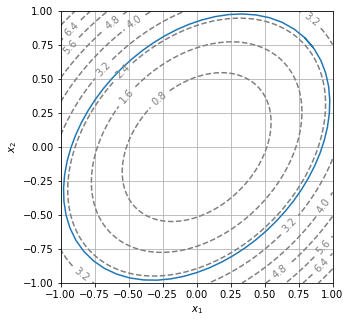

In [284]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
A=level_curvebis(f1,0.8,0.8)
X=A[:,0]
Y=A[:,1]
plt.plot(X,Y)
plt.show()

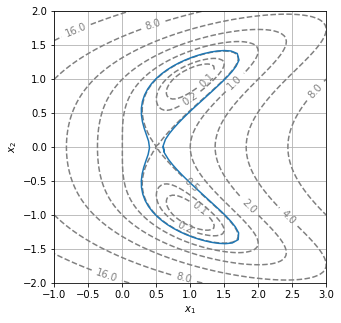

In [285]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
A=level_curvebis(f2,0.6,0.0)
X=A[:,0]
Y=A[:,1]
plt.plot(X,Y)
plt.show()

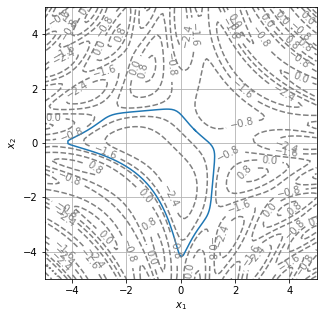

In [286]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
A=level_curvebis(f3,0.5,0.5)
X=A[:,0]
Y=A[:,1]
plt.plot(X,Y)
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [287]:
def area_squares(f,c,h,K):
    N=int((2*K)/h)
    S=0
    for i in range(N):
        for j in range(N):
            if (f(-K+i*h,-K+j*h)) < c:
                S+=1
    return S*(h**2)

On trouve que l'aire du disque unité vaut 3.1415249999999997


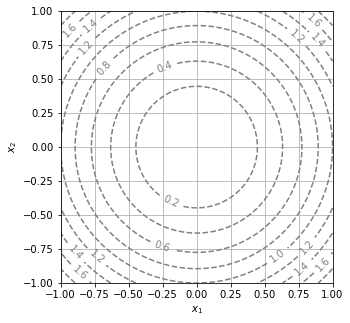

In [288]:
def f4(x,y):
    return (x**2+y**2)

display_contour(
    f4, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

print(f"On trouve que l'aire du disque unité vaut {area_squares(f4,1,1/1000,1)}")

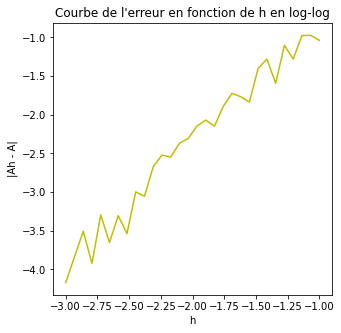

In [289]:

X=np.linspace(-3,-1,30)
Y=[np.log10(np.pi-area_squares(f4,1,10**(a),1)) for a in X]
plt.plot(X,Y,color = 'y')
plt.xlabel("h")
plt.ylabel("|Ah - A|")
plt.title("Courbe de l'erreur en fonction de h en log-log")
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


Avec cette approche, on peut calculer le nombre de petits carrés qui sont complètement inclus dans K (les quatres sommets sont dans K), cela nous donne une approximation inférieure.
De même, en considérant les petits carrés dont au moins un des coins est dans K, on surestimera l'aire.

In [290]:
def area_squares_level_up(f,c,h,K):
    
    N=int((2*K)/h)
    
    Sinf=0
    Ssup=0

    for i in range(N):
        for j in range(N):
            if (f(-K+i*h,-K+j*h)) < c and (f(-K+(i+1)*h,-K+j*h)) < c and (f(-K+i*h,-K+(j+1)*h)) < c and (f(-K+(i+1)*h,-K+(j+1)*h)) < c:
                Sinf+=1
            if (f(-K+i*h,-K+j*h)) < c or (f(-K+(i+1)*h,-K+j*h)) < c or (f(-K+i*h,-K+(j+1)*h)) < c or (f(-K+(i+1)*h,-K+(j+1)*h)) < c:
                Ssup+=1
    print (f"L'approximation inférieure est {Sinf*(h**2)}, l'approximation supérieure est {Ssup*(h**2)}.")

    return Sinf*(h**2),Ssup*(h**2)

area_squares_level_up(f4,1,1/100,1)

L'approximation inférieure est 3.1, l'approximation supérieure est 3.1796.


(3.1, 3.1796)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

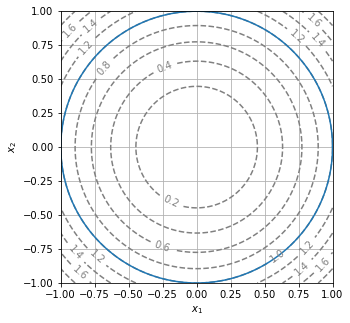

3.1410921299692447

In [291]:
def aire_triangle(f,x0,y0,delta,N=10000,xp=0,yp=0):
    A=level_curvebis(f,x0,y0,delta,N)
    Aire=0
    for i in range(len(A)-1) :
        Pteaire = (A[i+1,1]-A[i,1])*(xp-A[i,0])-(A[i+1,0]-A[i,0])*(yp-A[i,1])        
        Aire+=Pteaire/2
    return Aire

display_contour(
    f4, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
A=level_curvebis(f4,1.0,0.0,1/1000, 10000)
X=A[:,0]
Y=A[:,1]
plt.plot(X,Y)
plt.show()
aire_triangle(f4,0.0,1.0,1/1000)

In [292]:
print(f"Pour d=1, l'erreur est {abs(aire_triangle(f4,0.0,1.0,1)-np.pi)}")
print(f"Pour d=1/10, l'erreur est {abs(aire_triangle(f4,0.0,1.0,1/10)-np.pi)}")
print(f"Pour d=1/100, l'erreur est {abs(aire_triangle(f4,0.0,1.0,1/100)-np.pi)}")
print(f"Pour d=1/100, l'erreur est {abs(aire_triangle(f4,0.0,1.0,1/1000)-np.pi)}")
print("Ainsi la vitesse de la convergence est linéaire")

Pour d=1, l'erreur est 0.9765291392369955
Pour d=1/10, l'erreur est 0.05519079336842925
Pour d=1/100, l'erreur est 0.005052383564310592
Pour d=1/100, l'erreur est 0.0005005236205484209
Ainsi la vitesse de la convergence est linéaire


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [293]:
print(aire_triangle(f4,0.0,1.0,1/1000,10000,2,2))


3.1420926299689373


Explication : chaque aire infinitésimale est sur-estimée quand les points sont à l'opposé de (xp, yp), mais le surplus d'aire est enlevé quand on compte l'aire quand les points sont au plus proche de (xp, yp), petite aire qui est donc négative.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

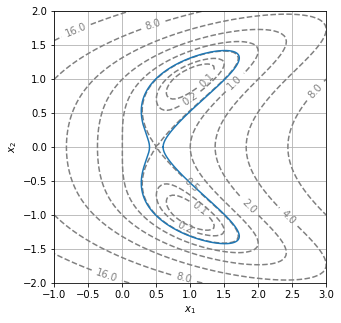

2.003558997379159

In [294]:
#Avec une courbe de niveau de f2 non convexe :
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
A=level_curvebis(f2,0.6,0.0,1/1000,10000)
X=A[:,0]
Y=A[:,1]
plt.plot(X,Y)
plt.show()

aire_triangle(f2,0.6,0.0,1/1000)

In [295]:
#Avec une réunion de deux cercles non disjoints
def f5(x,y):
    return min((x-1)**2+y**2, (x+1)**2+y**2)

aire_triangle(f5,3.0,0.0,1/1000,10000)

14.629155660669879

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [296]:
def area_triangle(x,y):
    Aire=0
    for i in range(len(x)-1) :
        Pteaire = (y[i+1]-y[i])*(-x[i])-(x[i+1]-x[i])*(-y[i])        
        Aire+=Pteaire/2
    return Aire



In [297]:
A=level_curvebis(f4,1.0,0.0,1/1000,10000)
X=A[:,0]
Y=A[:,1]

print (f"Avec la méthode des triangles, l'aire vaut {area_triangle(X,Y)}")
print(f"Avec la méthode des carrés, l'aire vaut {area_squares(f4,1.0,1/1000,1)}")


Avec la méthode des triangles, l'aire vaut 3.1410921299692447
Avec la méthode des carrés, l'aire vaut 3.1415249999999997


In [299]:
import time

start = time.time()
a=aire_triangle(f4,0.0,1.0,1/1000,10000)
end = time.time()
print(f"Méthode des triangles : \nLe temps néccessaire pour arriver à la valeur {a} est {end - start} sec \n \n")

start = time.time()
a=area_squares(f4,1.0,1/1000,1)
end = time.time()
print(f"Méthode des rectangles : \nLe temps néccessaire pour arriver à la valeur {a} est {end - start} sec")


Méthode des triangles : 
Le temps néccessaire pour arriver à la valeur 3.1410921299692447 est 6.112877607345581 sec 
 

Méthode des rectangles : 
Le temps néccessaire pour arriver à la valeur 3.1415249999999997 est 2.264899969100952 sec



Ainsi, les deux méthodes sont efficaces pour calculer des aires. Cependant, la méthode des rectangles est plus précise. On constate qu'elle donne un résultat plus précis pour un temps de calcul plus court.